# AI For Toxicology Screening



## Data Loading


### Adverse effect Data

In [1]:
# Import required libraries For Data Analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

In [ ]:
# Files to be uploaded locally

files.upload()

### APPROACH 2: Chemical SMILE Notation and Properties data

@Taqi, here I found a way to access pubchem database via a built in python module. We can use this to basically create a pandas dataframe which consists of chemical compounds and their different properties.

However for the sake of proof of concept, the data that I'm using on top of the pubchem db is unique for COVID-19 Drug Discovery purposes

**TL;DR, we are going to carry out feature extraction on this data, transferring the features into a pandas dataframe**

In [ ]:
# Install pubchem library to access the data
# !pip install pubchempy

In [2]:
import pubchempy as pcp

In [3]:
# See if we can get one row of this data

prop = pcp.get_properties(['MolecularFormula', 'MolecularWeight', 'CanonicalSMILES', 'IsomericSMILES',
'InChI', 'InChIKey', 'IUPACName'],'CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O)NC2=CC=C(Cl)C=C2)=N1', 'smiles')

In [5]:
print(prop)

print(f'data type:{type(prop)}')

[{'CID': 2821293, 'MolecularFormula': 'C21H15ClF3N5OS2', 'MolecularWeight': '510.0', 'CanonicalSMILES': 'CN1C(=CC(=N1)C2=CC=C(S2)C3=NC(=NC=C3)SCC(=O)NC4=CC=C(C=C4)Cl)C(F)(F)F', 'IsomericSMILES': 'CN1C(=CC(=N1)C2=CC=C(S2)C3=NC(=NC=C3)SCC(=O)NC4=CC=C(C=C4)Cl)C(F)(F)F', 'InChI': 'InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)10-15(29-30)17-7-6-16(33-17)14-8-9-26-20(28-14)32-11-19(31)27-13-4-2-12(22)3-5-13/h2-10H,11H2,1H3,(H,27,31)', 'InChIKey': 'AWQBIBTZJKFLEW-UHFFFAOYSA-N', 'IUPACName': 'N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(trifluoromethyl)pyrazol-3-yl]thiophen-2-yl]pyrimidin-2-yl]sulfanylacetamide'}]
data type:<class 'list'>


In [ ]:
# Uploaded data consisting of SMILES notation and pIC50 values of the chemicals
files.upload()

In [6]:
# Create the initial Pandas Dataframe (df)
df_chem_prop = pd.read_csv('DDH Data.csv')

In [6]:
df_chem_prop.describe()

,Compound No.,Unnamed: 3
count,104.000000,0.0
mean,52.500000,NaN
std,30.166206,NaN
min,1.000000,NaN
25%,26.750000,NaN
50%,52.500000,NaN
75%,78.250000,NaN
max,104.000000,NaN


In [14]:
df_chem_prop.head()

,Compound No.,SMILES,pIC50 (IC50 in microM),Unnamed: 3
0,1,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,-0.477121255,NaN
1,2,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,-1,NaN
2,3,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,-1.041392685,NaN
3,4,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,BLINDED,NaN
4,5,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,-1.146128036,NaN


In [7]:
data = []

# Iterate through our SMILES list, and cross reference with pubchem database to append additional properties
for i in df_chem_prop['SMILES']:
    props = pcp.get_properties(['MolecularFormula', 'MolecularWeight','InChI', 'InChIKey', 'IUPACName', 
                                'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 
                                'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 
                                'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount', 
                                'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 
                                'DefinedBondStereoCount', 'UndefinedBondStereoCount', 'CovalentUnitCount', 
                                'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D', 
                                'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D', 
                                'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D', 
                                'FeatureRingCount3D', 'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D', 
                                'EffectiveRotorCount3D', 'ConformerCount3D'], i, 'smiles')
    data.append(props)

In [8]:
data

[[{'CID': 2744814,
   'MolecularFormula': 'C21H14Cl2N4OS2',
   'MolecularWeight': '473.4',
   'InChI': 'InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9-14)25-19(28)12-30-21-24-7-6-17(27-21)18-11-29-20(26-18)13-4-2-1-3-5-13/h1-11H,12H2,(H,25,28)',
   'InChIKey': 'LILOEJREEQFTPM-UHFFFAOYSA-N',
   'IUPACName': 'N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thiazol-4-yl)pyrimidin-2-yl]sulfanylacetamide',
   'XLogP': 5.6,
   'ExactMass': '471.9986088',
   'MonoisotopicMass': '471.9986088',
   'TPSA': 121,
   'Complexity': 559,
   'Charge': 0,
   'HBondDonorCount': 1,
   'HBondAcceptorCount': 6,
   'RotatableBondCount': 6,
   'HeavyAtomCount': 30,
   'IsotopeAtomCount': 0,
   'AtomStereoCount': 0,
   'DefinedAtomStereoCount': 0,
   'UndefinedAtomStereoCount': 0,
   'BondStereoCount': 0,
   'DefinedBondStereoCount': 0,
   'UndefinedBondStereoCount': 0,
   'CovalentUnitCount': 1,
   'Volume3D': 341.3,
   'XStericQuadrupole3D': 9.21,
   'YStericQuadrupole3D': 5.63,
   'ZStericQuadrupole3D': 1.97,
  

In [9]:
num_feat = len(data[0][0].keys())

print(f'Number of features in the dataset: {num_feat}')

Number of features in the dataset: 38


In [10]:
rows = []
columns = data[0][0].keys()
for i in range(104):
    rows.append(data[i][0].values())

# Create the datafrane
props_df = pd.DataFrame(data=rows, columns=columns) 
props_df.head()

,CID,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,TPSA,...,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D
0,2744814,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.9986088,471.9986088,121.0,...,9.0,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0
1,2821293,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.0358646,509.0358646,126.0,...,9.0,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0
2,2820912,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.0130236,518.0130236,175.0,...,10.0,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0
3,2820914,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,NNVVKOVHRSDRSQ-UHFFFAOYSA-N,N-(2-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.0130236,518.0130236,175.0,...,10.0,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0
4,2744846,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.0049013,459.0049013,162.0,...,10.0,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0


In [11]:
# Append these chemical properties to original SMILES Dataset
props_df.insert(1, 'SMILES', df_chem_prop['SMILES'], True)
props_df['pIC50'] = df_chem_prop['pIC50 (IC50 in microM)']
props_df.head()

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.9986088,471.9986088,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.0358646,509.0358646,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.0130236,518.0130236,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
3,2820914,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,NNVVKOVHRSDRSQ-UHFFFAOYSA-N,N-(2-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.0130236,518.0130236,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
4,2744846,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.0049013,459.0049013,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036


In [12]:
# Saving this new dataset to the collab
props_df.to_csv('DDH Data with Properties.csv', index=False)

## Exploratory Data Analysis

In [13]:
df_prop = pd.read_csv('DDH Data with Properties.csv')

In [23]:
# doing this again for convention's sake 
df_prop.head()

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.998609,471.998609,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.035865,509.035865,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
3,2820914,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,NNVVKOVHRSDRSQ-UHFFFAOYSA-N,N-(2-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
4,2744846,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.004901,459.004901,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036


In [24]:
df_prop.describe()

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D
count,1.040000e+02,104.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.539089e+07,367.867981,3.207921,378.261335,378.221780,101.017822,576.336634,0.0,0.693069,5.732673,...,8.450000,3.750000,0.660000,0.230000,0.320000,3.220000,0.270000,0.798000,4.966000,8.890000
std,4.443420e+07,100.488055,1.609763,78.756938,78.695752,34.974503,156.648286,0.0,0.796776,1.859522,...,1.748737,1.200799,0.781348,0.489382,0.529532,0.847814,0.489382,0.221099,2.364733,2.692657
min,0.000000e+00,0.000000,-0.600000,212.007805,212.007805,34.100000,242.000000,0.0,0.000000,2.000000,...,4.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.600000,0.000000,1.000000
25%,2.799801e+06,309.092500,2.200000,310.120509,310.120509,83.100000,474.000000,0.0,0.000000,5.000000,...,7.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.600000,3.150000,10.000000
50%,1.393569e+07,370.850000,3.400000,372.089226,372.089226,96.900000,554.000000,0.0,0.000000,6.000000,...,9.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.800000,5.000000,10.000000
75%,7.305647e+07,431.425000,4.300000,434.104876,433.845920,120.000000,670.000000,0.0,1.000000,6.000000,...,9.250000,4.000000,1.000000,0.000000,1.000000,4.000000,0.250000,1.000000,7.000000,10.000000
max,1.354276e+08,588.600000,7.300000,588.177766,588.177766,197.000000,960.000000,0.0,3.000000,12.000000,...,13.000000,7.000000,3.000000,2.000000,2.000000,6.000000,2.000000,1.400000,12.000000,10.000000


In [14]:
prop_null_check = df_prop.isnull().sum().max()

print('Null Values in Heart DF: {}'.format(prop_null_check))

Null Values in Heart DF: 4


Unfortunately, there were 4 values in the dataframe which are missing. We may need to impute the data. 

Since the null values is relatively low, we may just consider deleting them from the data

In [15]:
# For the first run, I'm going to try imputing null values with zero
df_prop.replace(np.nan,0,inplace=True)

In [27]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CID                       104 non-null    int64  
 1   SMILES                    104 non-null    object 
 2   MolecularFormula          104 non-null    object 
 3   MolecularWeight           104 non-null    float64
 4   InChI                     104 non-null    object 
 5   InChIKey                  104 non-null    object 
 6   IUPACName                 104 non-null    object 
 7   XLogP                     104 non-null    float64
 8   ExactMass                 104 non-null    float64
 9   MonoisotopicMass          104 non-null    float64
 10  TPSA                      104 non-null    float64
 11  Complexity                104 non-null    float64
 12  Charge                    104 non-null    float64
 13  HBondDonorCount           104 non-null    float64
 14  HBondAccep

# EDA

In [16]:
df = df_prop[df_prop['pIC50'] != 'BLINDED']
#df.loc[df['pIC50']=='BLINDED',:]
df['pIC50']=df['pIC50'].astype('float64')

C:\Users\amutt\AppData\Local\Temp\ipykernel_25372\200087815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pIC50']=df['pIC50'].astype('float64')


C:\Users\amutt\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pIC50', ylabel='Density'>

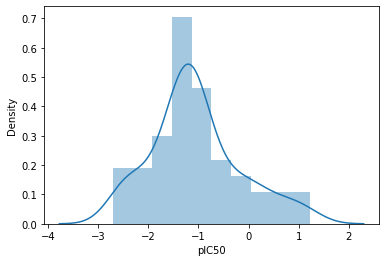

In [17]:
# Plot a distribution graph of pIC50
sns.distplot(df['pIC50'], kde=True)

Text(0.5, 1.0, 'Chemical Properties With Relation To Potency')

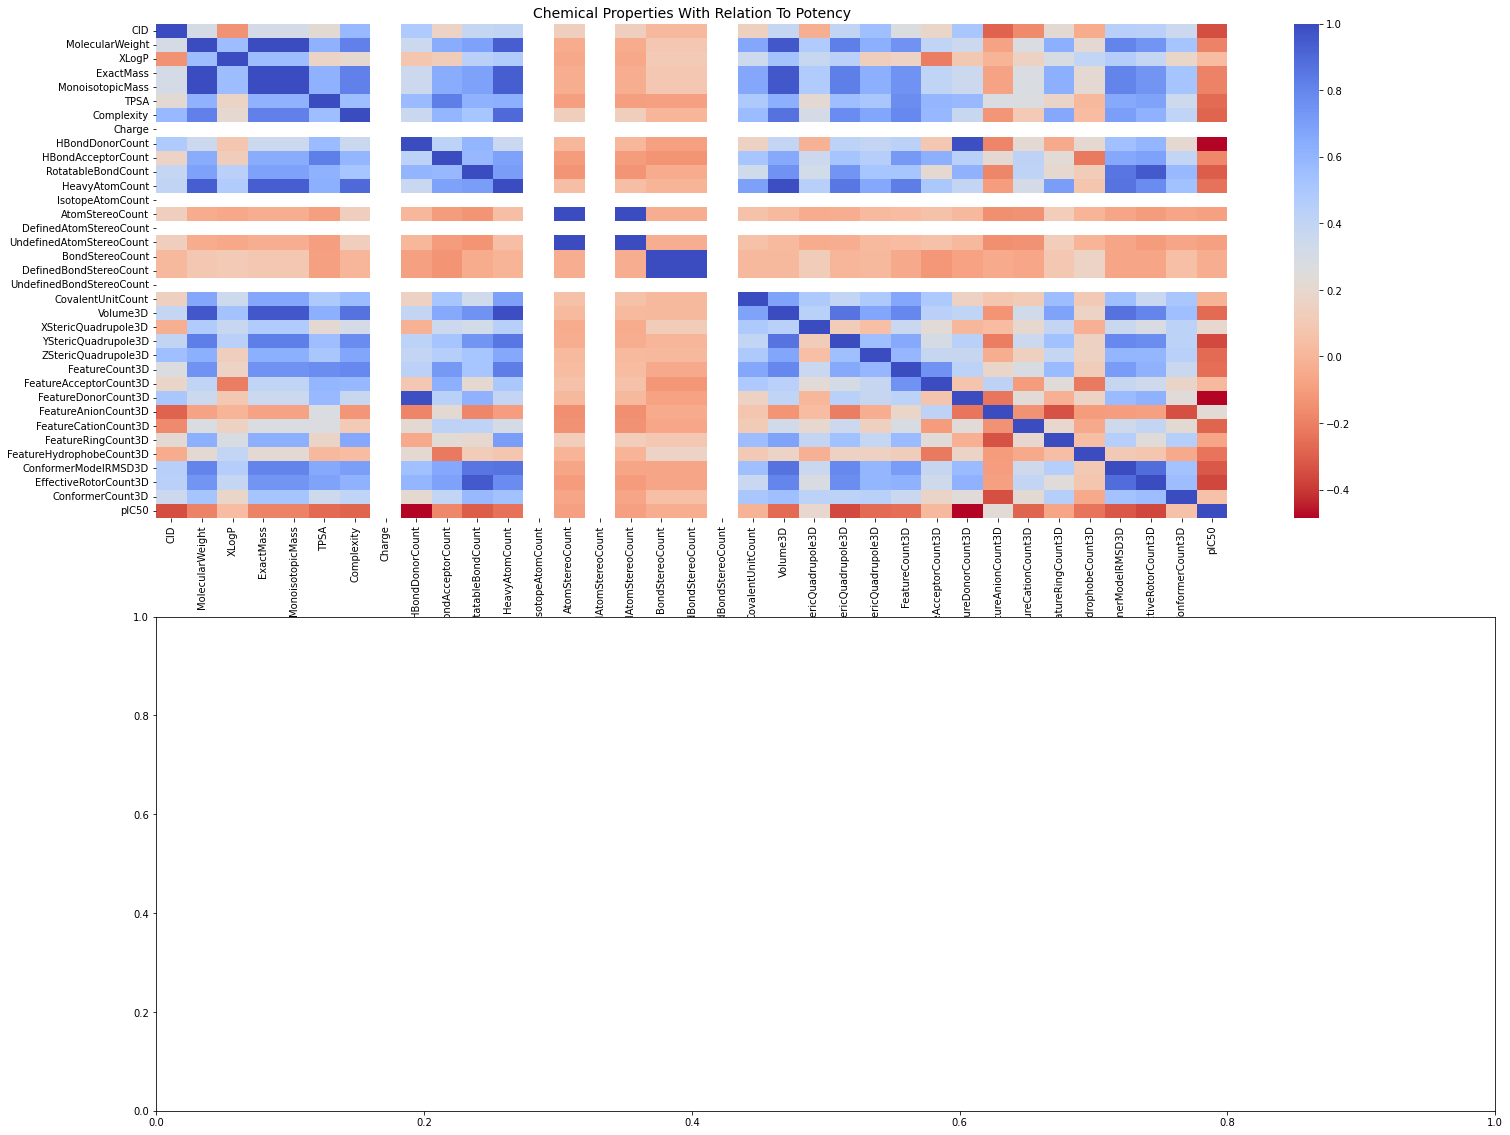

In [18]:
# Implementing Correlation Matrix

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Chemical Properties With Relation To Potency", fontsize=14)

### Key Features For Further Analysis
Negative correlation with pIC50 class

- HBond Donor Count
- Feature Donor Count 3D
- Effective Rotor Count
- Ysteric Quadruple Count


In [31]:
# Using this to copy paste into the boxplot analysis
df.columns

Index(['CID', 'SMILES', 'MolecularFormula', 'MolecularWeight', 'InChI',
       'InChIKey', 'IUPACName', 'XLogP', 'ExactMass', 'MonoisotopicMass',
       'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount',
       'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D', 'pIC50'],
      dtype='object')

Text(0.5, 1.0, 'YStericQuadrupole3D vs Class Negative Correlation')

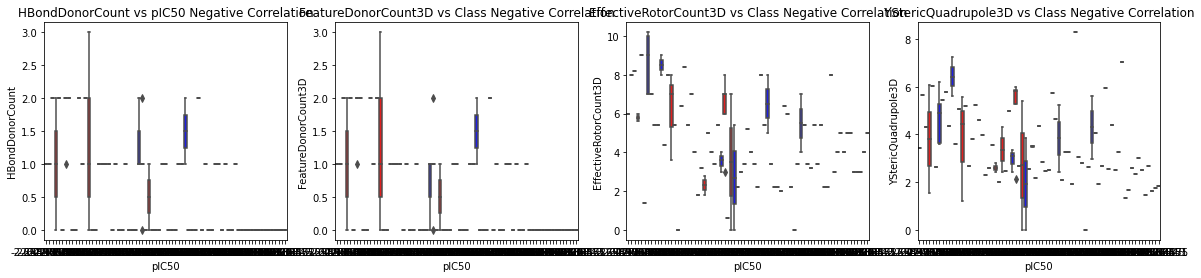

In [19]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['blue', 'red']

# Negative Correlations with pIC50 (The lower our feature value the more likely it will be increase drug potency)
sns.boxplot(x="pIC50", y="HBondDonorCount", data=df, palette=colors, ax=axes[0])
axes[0].set_title('HBondDonorCount vs pIC50 Negative Correlation')

sns.boxplot(x="pIC50", y="FeatureDonorCount3D", data=df, palette=colors, ax=axes[1])
axes[1].set_title('FeatureDonorCount3D vs Class Negative Correlation')


sns.boxplot(x="pIC50", y="EffectiveRotorCount3D", data=df, palette=colors, ax=axes[2])
axes[2].set_title('EffectiveRotorCount3D vs Class Negative Correlation')


sns.boxplot(x="pIC50", y="YStericQuadrupole3D", data=df, palette=colors, ax=axes[3])
axes[3].set_title('YStericQuadrupole3D vs Class Negative Correlation')

Text(0.5, 1.0, 'YStericQuadrupole3D vs pIC50 Negative Correlation')

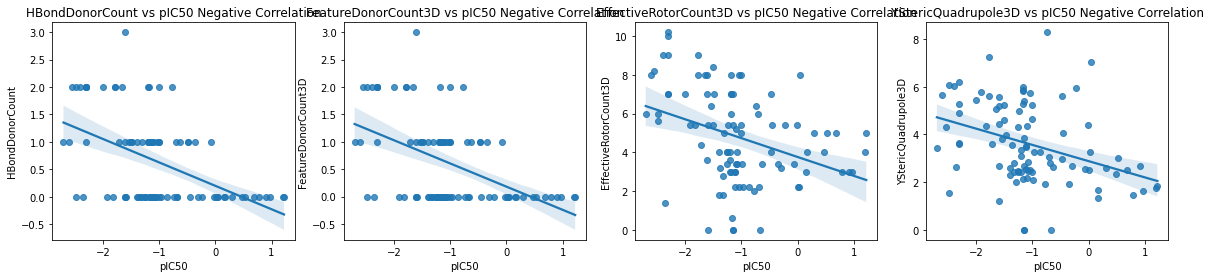

In [27]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['blue', 'red']

# Plot Linear Regression lines for the chemical properties that have negative correlation with pIC50 (the measure of potency of a drug)
sns.regplot(x='pIC50', y='HBondDonorCount', data=df, ax=axes[0])
axes[0].set_title('HBondDonorCount vs pIC50 Negative Correlation')

sns.regplot(x='pIC50', y='FeatureDonorCount3D', data=df, ax=axes[1])
axes[1].set_title('FeatureDonorCount3D vs pIC50 Negative Correlation')

sns.regplot(x='pIC50', y='EffectiveRotorCount3D', data=df, ax=axes[2])
axes[2].set_title('EffectiveRotorCount3D vs pIC50 Negative Correlation')

sns.regplot(x='pIC50', y='YStericQuadrupole3D', data=df, ax=axes[3])
axes[3].set_title('YStericQuadrupole3D vs pIC50 Negative Correlation')

## Data Transformations

## Model Training and Testing

# Model Evaluation

## Conclusion & Next Steps